In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import sys, os
import datetime
%load_ext autoreload
%autoreload 2

# data path, constants, etc.
import sys
datapath = '/Users/nhamilto/Documents/ATom/data/20180913_mictest/'
sys.path.append(datapath)

# plot things
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

# Acoustic tomography functions
import ATom.atom_functions as atom

# Microphone comparison
testing new B&K microphones against the old 'button' type.

In [2]:
oldfileindex = pd.read_csv(datapath+'old_mic_file_index_20181209.txt', delim_whitespace=True, skiprows=3)
newfileindex = pd.read_csv(datapath+'new_mic_file_index_20181209.txt', delim_whitespace=True, skiprows=3)

### load atom dataset object for meta data

In [3]:
adat = atom.dataset('/Users/nhamilto/Documents/ATom/data/20180913_Data_collection/')

### Load in data from the old mics

In [4]:
# column names in each data file
cols = ['S{}'.format(x) for x in range(8)] + ['M{}'.format(x) for x in range(8)]
# instantiate characterization data structure
chardata = pd.DataFrame()

# read in data from Mic 1
for ii in range(len(oldfileindex)):
    timestamp = oldfileindex['Filename/Timestamp'].iloc[ii].split('_')[0]
    fload = datapath + timestamp + '_AcouTomMainData' + '.txt'
    testdat = pd.read_csv(fload, skiprows=4, delim_whitespace=True, names=cols, usecols=['M0'])
    chardata[str(oldfileindex['OffsetAngle'].iloc[ii])] = testdat['M0'].values
    # grab some speaker data as well. It should be identical for every record, so only get one.
    if ii==0:
        speakerdat = pd.read_csv(fload, skiprows=4, delim_whitespace=True, names=cols, usecols=['S0'])
        speakerdat.set_index(pd.TimedeltaIndex(freq='50U', start=0, periods=len(speakerdat.index)), inplace=True)
        
# set index to be time delta from the beginning of each recording
chardata.set_index(pd.TimedeltaIndex(freq='50U', start=0, periods=len(chardata.index)), inplace=True)
old_mic_data = chardata.copy()

In [5]:
# calculate the number of frames within the file
nframe = int(len(speakerdat) / 10000)
frameindex = [
    speakerdat.index[0] + ii * pd.Timedelta(value=0.5, unit='s')
    for ii in range(nframe)
]
# add frame number as a series
framedata = ['frame {}'.format(ii) for ii in range(nframe)]
frameseries = pd.Series(data=framedata, index=frameindex)
speakerdat['frame'] = frameseries
speakerdat['frame'].ffill(inplace=True)

# reindex by both the frame number and the time index
speakerdat.set_index(['frame', speakerdat.index], inplace=True)

In [6]:
# calculate the number of frames within the file
nframe = int(len(chardata) / 10000)
frameindex = [
    chardata.index[0] + ii * pd.Timedelta(value=0.5, unit='s')
    for ii in range(nframe)
]
# add frame number as a series
framedata = ['frame {}'.format(ii) for ii in range(nframe)]
frameseries = pd.Series(data=framedata, index=frameindex)
chardata['frame'] = frameseries
chardata['frame'].ffill(inplace=True)

# reindex by both the frame number and the time index
chardata.set_index(['frame', chardata.index], inplace=True)

### extract a single speaker chirp

In [7]:
# single frame
speakersamp = speakerdat.xs('frame 0', level=0)
# constant parameters
chirp_record_length = adat.meta.chirp_record_length # samples within the chirp
upsamplefactor = 10
samplefreq = adat.meta.main_sampling_freq # Hz
searchLag = 3 * chirp_record_length * upsamplefactor

# upsample 
speakersamp = atom.upsample(speakersamp, upsamplefactor)
speakerstartindex = np.array([np.squeeze(speakersamp.values.round(5)).nonzero()[0][0]]) # atom.get_speaker_signal_delay(speakersamp) 

speakersig = speakersamp.values.squeeze()

(22000, 30000)

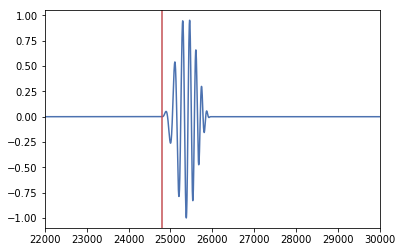

In [8]:
plt.plot(speakersamp.values)
plt.axvline(speakerstartindex, color='C2')
plt.xlim(22000, 30000)

In [9]:
# load aux data to get speed of sound
timestamp = oldfileindex['Filename/Timestamp'].iloc[0].split('_')[0]
fload = datapath + timestamp + '_AcouTomAuxData' + '.txt'
cols = ['vx','vy','vz','c','T','H']
auxdat = pd.read_csv(fload, skiprows=4, names=cols, delim_whitespace=True, usecols=['c'])
c0 = auxdat.values.mean()
signalETAs = np.array([2 / c0]) # seconds
signalETAs_index = (signalETAs*samplefreq*upsamplefactor).round()

etaindex = signalETAs_index + speakerstartindex 
etaindex = etaindex[:].repeat(len(chardata.columns))

### Extract mic signals



In [50]:
searchLag/2

1740.0

In [43]:
delay = np.zeros((len(chardata.columns), nframe))
alpha = delay.copy()
sortedcols = [str(int(x*10)) for x in range(-10,11)]
for fi in range(nframe):
    micsamp = chardata.xs('frame {}'.format(fi), level=0)
    micsamp = atom.freq_filter(micsamp, adat.meta.filter_freq_inds)
    micsamp = atom.upsample(micsamp, upsamplefactor)
    micsamp = micsamp.reindex(sortedcols, axis=1)

    sigshift = int((searchLag-chirp_record_length*upsamplefactor)/2)
    
    mstart = int(etaindex[0]-sigshift)
    mend = int(mstart + searchLag) 
    
    sstart = int(speakerstartindex-sigshift)
    send = int(sstart+searchLag)
    
    for ic, col in enumerate(micsamp.columns):
        temp = micsamp[col].values[mstart:mend]
        covar = np.correlate(temp, speakersig[sstart:send], mode='same')
        alpha[ic,fi] = int(col) 
        delay[ic,fi] = int(np.argmax(covar)-searchLag/2)
        
# from signal delay, calculate actual travel time of signal
traveltimes = signalETAs + delay/(samplefreq*upsamplefactor)

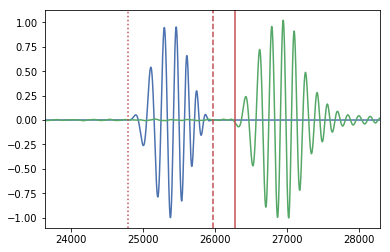

In [13]:
plt.plot(speakersig)
plt.plot(micsamp['0'].values/12)

plt.xlim(sstart,mend)

plt.axvline(speakerstartindex, color='C2', ls=':')
plt.axvline(etaindex[0], color='C2', ls='--')
plt.axvline(etaindex[0]+(np.argmax(covar)-searchLag/2), color='C2', ls='-')


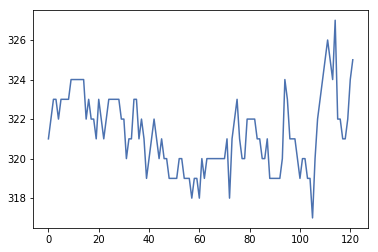

In [14]:
plt.plot(delay[12,:])

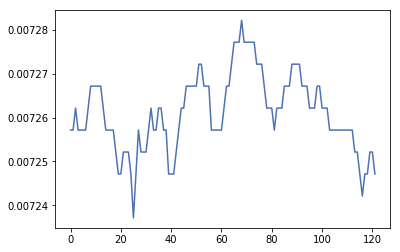

In [15]:
plt.plot(traveltimes[2,:])

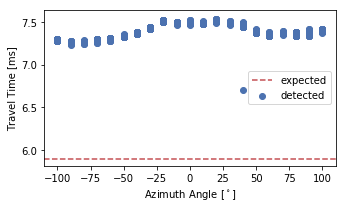

In [16]:
# time_r = (tr - speakerstartindex) / (samplefreq * upsamplefactor) * 1000

fig,ax = plt.subplots(figsize=(5,3))

ax.scatter(alpha.flatten(), traveltimes.flatten()*1000, label='detected')
ax.axhline(2.0/c0*1000, label='expected', ls='--', color='C2')

ax.set_xlabel('Azimuth Angle [$^\circ$]')
ax.set_ylabel('Travel Time [ms]')
ax.legend()

fig.tight_layout()
fig.savefig('../figures/old_mic_travel_time.png', dpi=200, bbox_inches='tight')

In [17]:
today = datetime.date.today().strftime('%Y%m%d')
savefile = os.path.join(datapath,today+'_oldmicdata.csv')
np.savetxt(savefile, traveltimes.T)

# Data from new microphone

In [18]:
# column names in each data file
cols = ['S{}'.format(x) for x in range(8)] + ['M{}'.format(x) for x in range(8)]
# instantiate characterization data structure
chardata = pd.DataFrame()
catdat = pd.DataFrame()

# read in data from Mic 1
for ii in range(len(newfileindex)):
    timestamp = newfileindex['Filename/Timestamp'].iloc[ii].split('_')[0]
    fload = datapath + timestamp + '_AcouTomMainData' + '.txt'
    testdat = pd.read_csv(fload, skiprows=4, delim_whitespace=True, names=cols, usecols=['M0'])
    newcol = str(newfileindex['OffsetAngle'].iloc[ii]) + '_' + str(ii%3)
    catdat = pd.concat([catdat, testdat.iloc[0:1200000]], ignore_index=True, axis=0) 
    if ii%3 == 2:
        if ii==2:
            chardata = catdat
        chardata[str(newfileindex['OffsetAngle'].iloc[ii])] = catdat
        del catdat
        catdat = pd.DataFrame()
    # grab some speaker data as well. It should be identical for every record, so only get one.
    if ii==0:
        speakerdat = pd.read_csv(fload, skiprows=4, delim_whitespace=True, names=cols, usecols=['S0'])
        speakerdat.set_index(pd.TimedeltaIndex(freq='50U', start=0, periods=len(speakerdat.index)), inplace=True)
        
# set index to be time delta from the beginning of each recording
chardata.drop('M0', axis=1, inplace=True)
chardata.set_index(pd.TimedeltaIndex(freq='50U', start=0, periods=len(chardata.index)), inplace=True)
new_mic_data = chardata.copy()

In [19]:
# calculate the number of frames within the file
nframe = int(len(chardata) / 10000)
frameindex = [
    chardata.index[0] + ii * pd.Timedelta(value=0.5, unit='s')
    for ii in range(nframe)
]
# add frame number as a series
framedata = ['frame {}'.format(ii) for ii in range(nframe)]
frameseries = pd.Series(data=framedata, index=frameindex)
chardata['frame'] = frameseries
chardata['frame'].ffill(inplace=True)

# reindex by both the frame number and the time index
chardata.set_index(['frame', chardata.index], inplace=True)

framelength = len(chardata.xs('frame 0', level=0))

In [20]:
# single frame
speakersamp = speakerdat.iloc[0:framelength]
# constant parameters
chirp_record_length = adat.meta.chirp_record_length # samples within the chirp
upsamplefactor = 10
samplefreq = adat.meta.main_sampling_freq
searchLag = 3 * chirp_record_length * upsamplefactor
# upsample 
speakersamp = atom.upsample(speakersamp, upsamplefactor)
speakerstartindex = np.array([np.squeeze(speakersamp.values.round(5)).nonzero()[0][0]]) 

speakersigs = atom.signalOnSpeaker(speakersamp, searchLag, chirp_record_length*upsamplefactor, speakerstartindex)


In [21]:
# load aux data to get speed of sound
timestamp = oldfileindex['Filename/Timestamp'].iloc[0].split('_')[0]
fload = datapath + timestamp + '_AcouTomAuxData' + '.txt'
cols = ['vx','vy','vz','c','T','H']
auxdat = pd.read_csv(fload, skiprows=4, names=cols, delim_whitespace=True, usecols=['c'])
c0 = auxdat.values.mean()
signalETAs = np.array([2 / c0])

etaindex = (signalETAs * samplefreq * upsamplefactor).round() + speakerstartindex 
etaindex = etaindex[:].repeat(len(micsamp.columns))

In [22]:
delay = np.zeros((len(chardata.columns), nframe))
alpha = delay.copy()
sortedcols = [str(int(x*10)) for x in range(-10,11)]
for fi in range(nframe):
    micsamp = chardata.xs('frame {}'.format(fi), level=0)
    micsamp = atom.freq_filter(micsamp, adat.meta.filter_freq_inds)
    micsamp = atom.upsample(micsamp, upsamplefactor)
    micsamp = micsamp.reindex(sortedcols, axis=1)

    sigshift = int((searchLag-chirp_record_length*upsamplefactor)/2)
    
    mstart = int(etaindex[0]-sigshift)
    mend = int(mstart + searchLag) 
    
    sstart = int(speakerstartindex-sigshift)
    send = int(sstart+searchLag)
    
    for ic, col in enumerate(micsamp.columns):
        temp = micsamp[col].values[mstart:mend]
        covar = np.correlate(temp, speakersig[sstart:send], mode='same')
        alpha[ic,fi] = int(col) 
        delay[ic,fi] = int(np.argmax(covar)-searchLag/2)
        
# from signal delay, calculate actual travel time of signal
traveltimes = signalETAs + delay/(samplefreq*upsamplefactor)

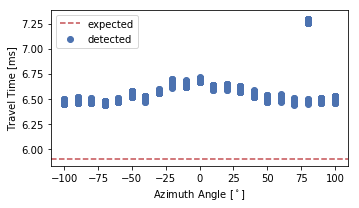

In [25]:

fig,ax = plt.subplots(figsize=(5,3))

ax.scatter(alpha.flatten(), traveltimes.flatten()*1000, label='detected')
ax.axhline(2.0/c0*1000, label='expected', ls='--', color='C2')

ax.set_xlabel('Azimuth Angle [$^\circ$]')
ax.set_ylabel('Travel Time [ms]')
ax.legend()

fig.tight_layout()
fig.savefig('../figures/new_mic_travel_time.png', dpi=200, bbox_inches='tight')

In [26]:
today = datetime.date.today().strftime('%Y%m%d')
savefile = os.path.join(datapath,today+'_newmicdata.csv')
np.savetxt(savefile, traveltimes.T)

## Re-load processed data for plotting

In [27]:
# data from new mic
newdat = pd.read_csv(os.path.join(datapath,today+'_newmicdata.csv'), 
                     delim_whitespace=True, names=[str(x) for x in alpha[:,0]])

In [28]:
# data from old mic
olddat = pd.read_csv(os.path.join(datapath,today+'_oldmicdata.csv'), 
                     delim_whitespace=True, names=[str(x) for x in alpha[:,0]])

#### Plot filtered data from new mic

In [32]:
avg_travel_times

array([3.23721669e-05, 3.24583474e-05, 3.24289030e-05, 3.23087641e-05,
       3.24353613e-05, 3.27818891e-05, 3.25234169e-05, 3.28891808e-05,
       3.32528613e-05, 3.32193891e-05, 3.34525835e-05, 3.31038335e-05,
       3.31033474e-05, 3.29982085e-05, 3.27330002e-05, 3.25206391e-05,
       3.25087641e-05, 3.23945974e-05,            nan, 3.24232780e-05,
       3.24425141e-05])

In [36]:
tstats['mean']*1000

-100.0    6.474433
-90.0     6.491669
-80.0     6.485781
-70.0     6.461753
-60.0     6.487072
-50.0     6.556378
-40.0     6.504683
-30.0     6.577836
-20.0     6.650572
-10.0     6.643878
0.0       6.690517
10.0      6.620767
20.0      6.620669
30.0      6.599642
40.0      6.546600
50.0      6.504128
60.0      6.501753
70.0      6.478919
80.0           NaN
90.0      6.484656
100.0     6.488503
Name: mean, dtype: float64

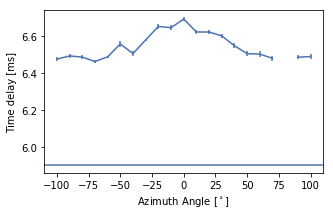

In [37]:
test = newdat.copy()
test['80.0'] = np.NaN
tstats = test.describe().T
# tstats['mean'].plot(yerr=tstats['std'])

az_angle = np.array([x*10 for x in range(-10,11)])
avg_travel_times = tstats['mean']*1000
std_travel_times = tstats['std']*1000

fig, ax = plt.subplots(figsize=(5,3))
ax.errorbar(az_angle, avg_travel_times, std_travel_times)
ax.set_xlabel('Azimuth Angle [$^\circ$]')
ax.set_ylabel('Time delay [ms]')
ax.axhline(2/c0*1000)#, '--', color='C2')

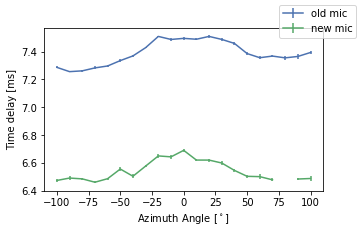

In [38]:
newstats = newdat.copy()
newstats['80.0'] = np.NaN
newstats = newstats.describe().T
# newstats['mean'] -= newstats['mean'].min()

oldstats = olddat.copy()
mask = (oldstats < oldstats.quantile(q=0.01))
oldstats[mask] = np.NaN
oldstats = oldstats.describe().T
# oldstats['mean'] -= oldstats['mean'].min()

fig, ax = plt.subplots(figsize=(5,3))
ax.errorbar(np.array([x*10 for x in range(-10,11)]), oldstats['mean']*1000, yerr=oldstats['std']*1000)

ax.errorbar(np.array([x*10 for x in range(-10,11)]), newstats['mean']*1000, yerr=newstats['std']*1000)
ax.set_xlabel('Azimuth Angle [$^\circ$]')
ax.set_ylabel('Time delay [ms]')

fig.legend(['old mic','new mic'])

In [102]:
from scipy import optimize

def cosine_fit_func(x, a, b, c):
    return a * np.cos(b * x)+c

### Speaker characterization data
signal latency at several fixed radial distances from the center of the speaker aperature as a function of azimuth angle

In [103]:
colnames = ['azangle'] + [x for x in range(120)]
speaker = pd.read_csv('../../data/speaker_char_raw_data_210818.csv', names=colnames, skiprows=1)

speaker['azangle'].ffill(inplace=True)
speaker = speaker.set_index('azangle').drop('4m', axis=0)
speaker.set_index(pd.to_numeric(speaker.index), inplace=True)
speaker['radius'] = np.concatenate(((2*np.ones(int(len(speaker.index)/2))).astype(int), (4*np.ones(int(len(speaker.index)/2+1))).astype(int)))
speaker.reset_index(inplace=True)
speaker.set_index(['radius','azangle'], inplace=True)


- calculate mean offset time,
- exclude outliers,
- separate by radial distance, 
- subtract minimum value, 

In [128]:
# get mean values over 120 records
meanoff = speaker.T.mean()

# remove and replace obvious outliers
meanoff.loc[2,[-40,40]] = np.nan
meanoff.interpolate(inplace=True)
meanoff.loc[4,[-100]] = np.nan
meanoff.bfill(inplace=True)

# extract data for radial distance = 2 m
rad2 = meanoff.xs(2, level=0) - meanoff.xs(2, level=0).min()
rad2 = rad2.reset_index()
rad2.columns = ['azangle', 'offset']

# extract data for radial distance = 4 m
rad4 = meanoff.xs(4, level=0) - meanoff.xs(4, level=0).min()
rad4 = rad4.reset_index()
rad4.columns = ['azangle', 'offset']

# fit cosine curve to data
rad2params, params_covariance = optimize.curve_fit(cosine_fit_func, np.radians(rad2['azangle']), rad2['offset'], p0=[0.15, 2, 0.15])
rad4params, params_covariance = optimize.curve_fit(cosine_fit_func, np.radians(rad4['azangle']), rad4['offset'], p0=[0.15, 2, 0.15])

rad2fit = cosine_fit_func(np.radians(rad2['azangle']), rad2params[0], rad2params[1], rad2params[2])
rad4fit = cosine_fit_func(np.radians(rad4['azangle']), rad4params[0], rad4params[1], rad4params[2])

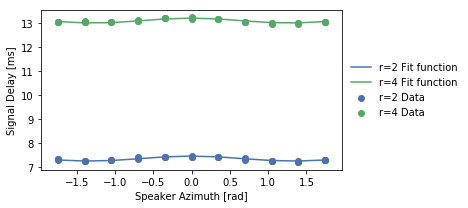

In [125]:
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(np.radians(rad2['azangle']), rad2['offset'], label='r=2 Data')
ax.plot(np.radians(rad2['azangle']), rad2fit,
         label='r=2 Fit function')

ax.scatter(np.radians(rad4['azangle']), rad4['offset'], label='r=4 Data', color='C1')
ax.plot(np.radians(rad4['azangle']), rad4fit,
         label='r=4 Fit function', color='C1')

ax.legend(loc=6, bbox_to_anchor=(1,0.5), frameon=False)

ax.set_xlabel('Speaker Azimuth [rad]')
ax.set_ylabel('Signal Delay [ms]')

fig.tight_layout()
fig.savefig('../figures/speaker_char_time_offsets.png', dpi=200, bbox_inches='tight')

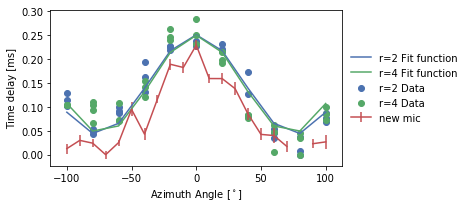

In [130]:
newstats = newdat.copy()
newstats['80.0'] = np.NaN
newstats = newstats.describe().T
newstats['mean'] -= newstats['mean'].min()

oldstats = olddat.copy()
mask = (oldstats < oldstats.quantile(q=0.01))
oldstats[mask] = np.NaN
oldstats = oldstats.describe().T
# oldstats['mean'] -= oldstats['mean'].min()

fig, ax = plt.subplots(figsize=(5,3))
# ax.errorbar(np.array([x*10 for x in range(-10,11)]), 
#             oldstats['mean'].values/(samplefreq*upsamplefactor/1000), 
#             yerr=oldstats['std']/(samplefreq*upsamplefactor/1000),
#            label='old mic, new data')

ax.errorbar(np.array([x*10 for x in range(-10,11)]), 
            newstats['mean'].values/(samplefreq*upsamplefactor/1000), 
            yerr=newstats['std']/(samplefreq*upsamplefactor/1000),
            label='new mic', color='C2')

ax.scatter(rad2['azangle'], rad2['offset'], label='r=2 Data')
ax.plot(rad2['azangle'], rad2fit,
         label='r=2 Fit function')

ax.scatter(rad4['azangle'], rad4['offset'], label='r=4 Data', color='C1')
ax.plot(rad4['azangle'], rad4fit,
         label='r=4 Fit function', color='C1')

ax.legend(loc=6, bbox_to_anchor=(1,0.5), frameon=False)

ax.set_xlabel('Azimuth Angle [$^\circ$]')
ax.set_ylabel('Time delay [ms]')

fig.tight_layout()
fig.savefig('../figures/new_mic_test.png', dpi=200, bbox_inches='tight')

In [135]:
old_mic_data.shape

(1220000, 21)

In [136]:
new_mic_data.shape

(3600000, 21)

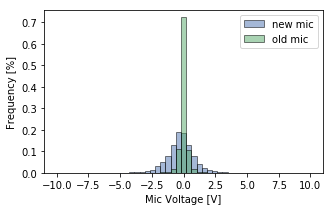

In [196]:
fig,ax = plt.subplots(figsize=(5,3))

ax.hist(new_mic_data['0'], bins = np.linspace(-10,10,50), 
        weights=np.ones(len(new_mic_data['0']))/len(new_mic_data['0']), 
        edgecolor='k', alpha=0.5)
ax.hist(old_mic_data['0'], bins = np.linspace(-10,10,50), 
        weights=np.ones(len(old_mic_data['0']))/len(old_mic_data['0']), 
        edgecolor='k', alpha=0.5)

ax.set_xlabel('Mic Voltage [V]')
ax.set_ylabel('Frequency [%]')

ax.legend(['new mic','old mic'])
fig.savefig('../figures/mic_hist.png', dpi=200, bbox_inches='tight')

In [181]:
new0 = np.abs(np.fft.fft(new_mic_data['0'].values))**2
newfreqs = np.fft.fftfreq(len(new_mic_data['0'].values), d=1/20000)

old0 = np.abs(np.fft.fft(old_mic_data['0'].values))**2
oldfreqs = np.fft.fftfreq(len(old_mic_data['0'].values), d=1/20000)


In [ ]:
adat.meta.chirp_freq-adat.meta.chirp_bandWidth/2

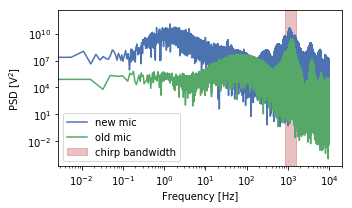

In [200]:
fig=plt.figure(figsize=(5,3))

plt.plot(newfreqs[0:int(len(new0)/2)], new0[0:int(len(new0)/2)], label='new mic')
plt.plot(oldfreqs[0:int(len(old0)/2)], old0[0:int(len(old0)/2)], label='old mic')

plt.yscale('log')
plt.xscale('log')

plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V$^2$]')

band = plt.axvspan(1000*(adat.meta.chirp_freq-adat.meta.chirp_bandWidth/2), 
            1000*(adat.meta.chirp_freq+adat.meta.chirp_bandWidth/2), 
                  color='C2', alpha=0.35, label='chirp bandwidth')

plt.legend()

fig.tight_layout()
fig.savefig('../figures/mic_psd.png', dpi=200, bbox_inches='tight')